# Fundamental Analysis
This notebook plots various fundamental statistics of different stocks.  
These links were helpful:  
https://simply-python.com/2015/02/13/getting-historical-financial-statistics-of-stock-using-python/  
http://stackoverflow.com/questions/40139537/scrape-yahoo-finance-financial-ratios  
https://automatetheboringstuff.com/chapter11/  
http://docs.python-guide.org/en/latest/scenarios/scrape/  

## Todo
- See the Learning rate, to determine if I'm limited by my sample size...
- Check classification instead of regression as well - will the stock go up or down? Looks imbalanced set though...
- Maybe try predicting only 6 months in advance instead of a year.

In [1]:
import pandas as pd
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from pandas.tseries.offsets import BMonthEnd
from pattern.web import URL
%matplotlib inline

## Choose Sector to analyze
- Important to analyze stocks from the same sector, as different sectors have different standards. E.g. a typical Debt/Equity ratio of one sector can be very different from another sector.  
- Download stock lists from http://www.nasdaq.com/screening/industries.aspx  

In [2]:
#tickers = pd.read_csv('csv/s&p500.csv',delimiter=",")
#tickers = pd.read_csv('csv/wilshire5000.csv',delimiter=",")
industry = 'Consumer_Services'
tickers = pd.read_csv('csv/nasdaq/%s.csv'%industry,delimiter=",")
tickers.head()

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,FLWS,"1-800 FLOWERS.COM, Inc.",9.50,6.201760e+08,n/a,1999,Consumer Services,Other Specialty Stores,http://www.nasdaq.com/symbol/flws,NaN
1,WBAI,500.com Limited,13.32,5.527541e+08,n/a,2013,Consumer Services,Services-Misc. Amusement & Recreation,http://www.nasdaq.com/symbol/wbai,NaN
2,AHC,A.H. Belo Corporation,6.50,1.408957e+08,n/a,n/a,Consumer Services,Newspapers/Magazines,http://www.nasdaq.com/symbol/ahc,NaN
3,ANF,Abercrombie & Fitch Company,11.69,7.911206e+08,n/a,n/a,Consumer Services,Clothing/Shoe/Accessory Stores,http://www.nasdaq.com/symbol/anf,NaN
4,AKR,Acadia Realty Trust,32.15,2.599758e+09,n/a,n/a,Consumer Services,Real Estate Investment Trusts,http://www.nasdaq.com/symbol/akr,NaN


## Get Data

In [3]:
#scrape financial data from Morningstar
def get_stock_financials(stock,year):
    #pre-load stuff
    path = "Fundamental_Analysis/"
    skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
    del_if_present = ['AUD','EUR','BRL','CAD','ARS','CHF','CLP','CNY','COP','GBP','ILS','INR','JPY','KRW','MXN','PEN']
    del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
    #scrape/load data
    try:
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    except:
        webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
        url = URL(webpage)
        f = open('%s%s_keyratios.csv'%(path, stock), 'wb') #save key ratios
        f.write(url.download())
        f.close()
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    d = d.transpose().reset_index()
    #delete annoying repeated columns, ignore if non-US stocks for consistency
    for dip in del_if_present:
        if np.any(d.columns.str.contains(dip)):            #delete if present
            return pd.DataFrame(columns=d.columns)         #return empty dataframe so that this entry will be ignored
    d = d.dropna(axis='columns', how='all')
    for dc in del_columns: 
        try:
            del d[dc]
        except:
            pass
    #isolate desired year
    d = d[d['index'].str.contains("%d"%year)] 
    #final additions
    d.insert(0,'Stock',stock)                              #keep stock ticker
    date = last_weekday_of_month(d['index'].values[0])
    d.insert(1,'Price',DataReader(stock,'yahoo',date,date)['Adj Close'].values[0]) #get stock price
    return d

#small helper function for getting target
def last_weekday_of_month(date):
    return pd.date_range(date, periods=1, freq='BM')

#scrapes data from yahoo, gets target
def get_frac_price_change(stock,date):
    last_current = last_weekday_of_month(date)
    ds = date.split('-')
    last_future = last_weekday_of_month('%d-%s'%(int(ds[0])+1, ds[1]))
    current_price = DataReader(stock, 'yahoo', last_current, last_current)['Adj Close'].values[0]
    future_price = DataReader(stock, 'yahoo', last_future, last_future)['Adj Close'].values[0]
    return (future_price - current_price)/current_price
    
#simple progress bar
def progress(sequence, every=10):
    length = float(len(sequence))
    for index, item in enumerate(sequence):
        if index % every == 0:
            print >>sys.stderr, index/length,
        yield item
    
#Top-level function which acquires all the data
def get_data(stocks,year):
    #create empty dataframe with available columns
    cols = get_stock_financials(stocks["Symbol"][0],year).columns
    X = pd.DataFrame(columns=cols)
    y = []
    skip = []
    for s in progress(stocks["Symbol"], len(stocks["Symbol"])/10):
        try:
            _X = get_stock_financials(s,year)
            _y = get_frac_price_change(s,_X['index'].values[0])
            if _X.shape[1] > 1 and _y: #only append if alg actually recovered data
                X = X.append(_X)
                y.append(_y)
        except:
            skip.append(s)
    X = X.set_index('Stock')
    #X = pd.to_numeric(X)
    X = X.convert_objects(convert_numeric=True)
    return X, y, skip

In [4]:
year = 2015
stocks = pd.read_csv('csv/nasdaq/%s.csv'%industry,delimiter=",")
stocks = stocks.loc[stocks['MarketCap']>1e7]  #exclude stocks with small market cap

#get data - this will take a minute!
X, y, skip = get_data(stocks, year)

0.0 0.0997409326425 0.199481865285 0.299222797927 0.39896373057 0.498704663212 0.598445595855 0.698186528497 0.79792746114 0.897668393782 0.997409326425/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:76: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [5]:
#X['Debt/Equity'] = pd.to_numeric(X['Debt/Equity'])
#X = X.convert_objects(convert_numeric=True)

## Engineer Features and Process Data
Grab columns of interest to be used, replace NaN values, get training/test sets.

In [12]:
#delete columns with >10% NaN values...
#...for remaining columns, replace NaN values with median
for c in X.columns:
    frac_NaN = X[c].isnull().sum()/float(len(X))
    if frac_NaN > 0.1:
        del X[c]
        print "**Deleted** %s: NaN fraction = %.4f"%(c, frac_NaN)
    else:
        try:
            X[c] = pd.to_numeric(X[c])
            X[c].fillna(X[c].median(), inplace=True)
            print "%s: NaN fraction = %.4f"%(c, frac_NaN)
        except:
            print "couldnt convert %s column to numeric. NaN fraction=%.4f"%(c, frac_NaN)

Accounts Receivable: NaN fraction = 0.0000
Asset Turnover: NaN fraction = 0.0000
Asset Turnover (Average): NaN fraction = 0.0000
Book Value Per Share * USD: NaN fraction = 0.0000
COGS: NaN fraction = 0.0000
Cap Ex as a % of Sales: NaN fraction = 0.0000
Cash & Short-Term Investments: NaN fraction = 0.0000
Current Ratio: NaN fraction = 0.0000
EBT Margin: NaN fraction = 0.0000
Earnings Per Share USD: NaN fraction = 0.0000
Financial Leverage: NaN fraction = 0.0000
Financial Leverage (Average): NaN fraction = 0.0000
Fixed Assets Turnover: NaN fraction = 0.0000
Free Cash Flow Per Share * USD: NaN fraction = 0.0000
Free Cash Flow USD Mil: NaN fraction = 0.0000
Free Cash Flow/Net Income: NaN fraction = 0.0000
Free Cash Flow/Sales %: NaN fraction = 0.0000
Gross Margin: NaN fraction = 0.0000
Gross Margin %: NaN fraction = 0.0000
Net Income USD Mil: NaN fraction = 0.0000
Net Int Inc & Other: NaN fraction = 0.0000
Net Margin %: NaN fraction = 0.0000
Net PP&E: NaN fraction = 0.0000
Operating Income

In [7]:
X.columns

Index([u'Accounts Receivable', u'Asset Turnover', u'Asset Turnover (Average)',
       u'Book Value Per Share * USD', u'COGS', u'Cap Ex as a % of Sales',
       u'Cash & Short-Term Investments', u'Current Ratio', u'EBT Margin',
       u'Earnings Per Share USD', u'Financial Leverage',
       u'Financial Leverage (Average)', u'Fixed Assets Turnover',
       u'Free Cash Flow Per Share * USD', u'Free Cash Flow USD Mil',
       u'Free Cash Flow/Net Income', u'Free Cash Flow/Sales %',
       u'Gross Margin', u'Gross Margin %', u'Net Income USD Mil',
       u'Net Int Inc & Other', u'Net Margin %', u'Net PP&E',
       u'Operating Income USD Mil', u'Operating Margin', u'Operating Margin %',
       u'Other Current Assets', u'Other Long-Term Assets',
       u'Other Long-Term Liabilities', u'Price', u'Quick Ratio',
       u'Return on Assets %', u'Return on Equity %', u'Revenue', u'SG&A',
       u'Shares Mil', u'Total Assets', u'Total Current Assets',
       u'Total Current Liabilities', u'Total Lia

In [8]:
#feature engineering
X['Working Capital Ratio'] = X['Total Assets']/X['Total Liabilities']   #how easily that company can turn assets into cash to pay short-term obligations
X['P/E Ratio'] = X['Price']/X['Earnings Per Share USD']                 #investors' assessment of future earnings
X['P/B Ratio'] = X['Price']/X['Book Value Per Share * USD']
X['D/E Ratio'] = X['Total Liabilities']/X["Total Stockholders' Equity"] #debt/equity ratio

#features to include for analysis
percentiles = ['Net Margin %','Return on Equity %','Return on Assets %','Operating Margin %','Free Cash Flow/Sales %',
              'Gross Margin %']
ratios = ['Book Value Per Share * USD', 'Earnings Per Share USD','Free Cash Flow Per Share * USD','EBT Margin',
          'Working Capital Ratio','P/E Ratio','P/B Ratio', 'D/E Ratio', 'Asset Turnover', 'Quick Ratio', 
          'Current Ratio', 'Financial Leverage']

features = percentiles + ratios

In [9]:
XX = X[features]

In [10]:
XX.head()

,Net Margin %,Return on Equity %,Return on Assets %,Operating Margin %,Free Cash Flow/Sales %,Gross Margin %,Book Value Per Share * USD,Earnings Per Share USD,Free Cash Flow Per Share * USD,EBT Margin,Working Capital Ratio,P/E Ratio,P/B Ratio,D/E Ratio,Asset Turnover,Quick Ratio,Current Ratio,Financial Leverage
Stock,,,,,,,,,,,,,,,,,,
FLWS,1.81,10.36,5.27,3.4,8.31,43.4,3.35,0.30,1.89,2.70,1.710279,34.866667,3.122388,1.407898,2.91,0.38,1.29,2.40
AHC,-6.56,-14.65,-6.86,-6.7,-4.55,42.4,5.63,-0.84,-2.09,-7.26,2.135383,-5.552792,0.828480,0.880760,1.05,2.82,3.17,1.88
ANF,1.38,3.32,1.94,3.0,3.68,61.8,20.12,0.71,3.46,2.65,2.245677,33.732790,1.190372,0.802776,1.39,1.18,2.40,1.80
AKR,30.24,6.10,2.28,28.8,-181.90,73.1,15.49,0.94,-7.32,69.85,1.569612,34.072463,2.067664,1.755580,0.08,1.48,1.97,2.76
ATV,-84.46,-29.80,-21.92,-85.9,-47.02,26.6,23.82,-10.20,-11.37,-83.79,3.858025,-0.533333,0.228380,0.349892,0.26,0.82,1.72,1.35


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.2, random_state=42)

## Machine Learning tyme
Do an initial search with a high learning rate and few n_estimators, then do a second tune with lower learning rate and many more estimators.  

In [14]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
xgb.XGBRegressor()

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

#### Best params so far
-0.111054839795
{'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 0.1}

In [27]:
model = xgb.XGBRegressor()
n_cv = 3
n_iter = 15     #number of RandomizedSearchCV search iterations
param_grid={
    'learning_rate': [0.1],
    'max_depth': [2,4,8,16],
    'min_child_weight': [0.1,0.5,1,3],
    'colsample_bytree': [0.2,0.5,1],
    'gamma': [0,0.2,0.4],
    'n_estimators':[1000],
}

grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv=n_cv, scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

-0.131820566889
{'colsample_bytree': 1, 'learning_rate': 0.1, 'min_child_weight': 3, 'n_estimators': 1000, 'max_depth': 16, 'gamma': 0.4}


In [28]:
#Do final train with best parameters, lower learning rate and more estimators
model = xgb.XGBRegressor()
best_params={
    'learning_rate': [1e-2],
    'n_estimators':[3000],
    'max_depth': [16],
    'min_child_weight': [3],
    'colsample_bytree': [1],
    'gamma': [0.4],
}
final_model = GridSearchCV(model, param_grid=best_params, scoring='neg_mean_squared_error')
final_model.fit(X_train,y_train)

#best model
xgb_model = final_model.best_estimator_
print(final_model.best_score_)

-0.129371644896


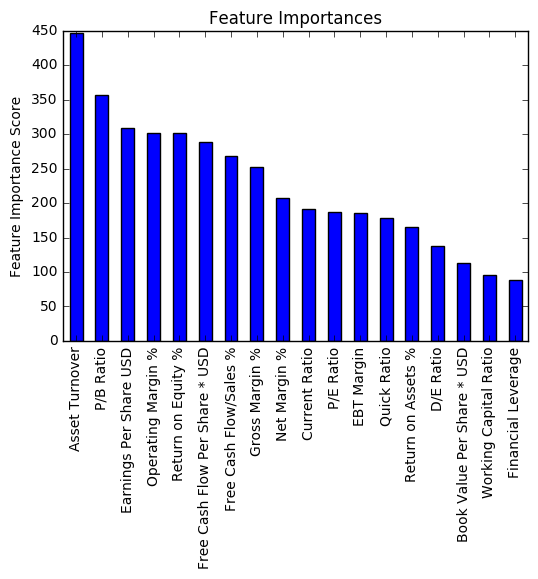

In [29]:
#seems equivalent to model.feature_importances_
feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False) 
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [30]:
y_test_predict = xgb_model.predict(X_test)

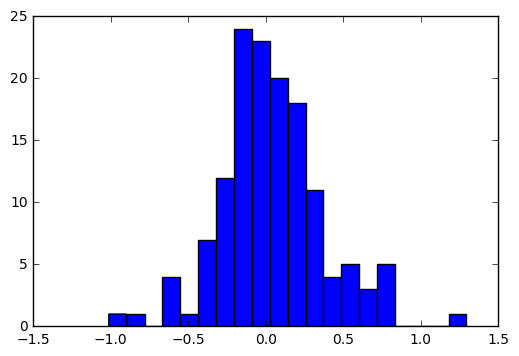

In [31]:
_,_,_ = plt.hist((y_test_predict - y_test), 20)

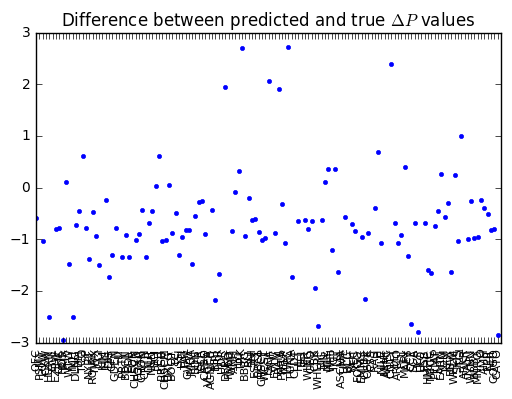

In [33]:
#plt.plot(y_test_predict, '.', label='predicted')
#plt.plot(y_test, '.', label='true')
plt.plot((y_test_predict - y_test)/y_test, '.')
plt.legend(fontsize=8, numpoints=1)
plt.xticks(range(len(y_test)), X_test.index, rotation='vertical', fontsize=8)
#plt.xlim([40,80])
plt.ylim([-3,3])
plt.title('Difference between predicted and true $\Delta P$ values');

# Extra

In [ ]:
# param_grid={
#     'learning_rate': [0.01],
#     'max_depth': [4],
#     'min_child_weight': [0.1],
#     'n_estimators':[2000],
# }
#grid = GridSearchCV(model, param_grid=param_grid, cv=n_cv, scoring='neg_mean_squared_error')

In [38]:
#s = "AA"
#data = get_stock_financials(s,2014)
#start = data['index'].values[0]
#get_frac_price_change(s,start)

#a= get_stock_price_change("ACN",start)
#print a

In [33]:
#This is useful scraping code for extracting the sector that each stock is from...
#http://docs.python-guide.org/en/latest/scenarios/scrape/
from lxml import html
import requests
def get_sectors(df,path):
    sectors = ['financials', 'healthcare', 'energy', 'basic-materials', 'industrials', 
           'technology', 'telecoms', 'utilities', 'non-cyclicals']
    df['Sector'] = ''
    DNF = []
    for i,st in enumerate(df['Ticker']):
        url = "http://www.reuters.com/finance/stocks/overview?symbol=%s"%st
        page = requests.get(url)
        tree = html.fromstring(page.content)
        found_sector = 0
        for sec in sectors:
            if len(tree.xpath('//a[@href="/sectors/%s"]/text()'%sec)) > 0:
                df["Sector"].iloc[i] = sec
                found_sector = 1
        if found_sector == 0:
            DNF.append(st)
            #print 'couldnt find sector for %s'%st
    df.to_csv(path)
    print "%f stocks did not have a sector found"%float(len(DNF))/float(len(df['Ticker']))
    return df, DNF

In [32]:
df, dnf = get_sectors(tickers,'csv/wilshire5000_sectors.csv')

In [24]:
stock = "AEM"
webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
url = URL(webpage)
f = open('Fundamental_Analysis/%s_keyratios.csv'%stock, 'wb') # save as test.gif
f.write(url.download())
f.close()